# Getting the data and processing the video

## Objective:

    Use openCV to read videos frame by frame. Use matplotlib or openCV to save 
    the frames as images. Use openCV to compare frames from genuine and Deepfake videos. You can compute a simple difference between original and Deepfake frames and save the difference as an image. You can also compare the histograms of original and Deepfake frames.



## Workflow

    1. Use Python Glob library to recursively iterate through both real and fake videos folders.
    2. Use a popular openCV library for image and video processing and analysis to loop through the frames of each video.
    3. Save frames as JPEG images for one original (your choice) and the corresponding Deepfake video to the disk. You can use matplotlib or openCV to do so.
    4. Take one frame from an original video and the same frame from the corresponding Deepfake. Find difference between these two frames and save it as an image to visually see the difference.
    5. Compute histograms for these two frames (one from original video and the corresponding one from Deepfake) and visualize them with matplotlib. What does the difference look like?
    6. Observe what makes video frames from Deepfake videos look different compared to originals.*



Firstly loading the modules that script need.

In [2]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
import imutils
import cv2

In [56]:
f = 1
pat = os.getcwd()    # getting the full path to actual folder
path = pat           # copy of path because in upyther recursion changes the oryginal

def getting_data(pat, sample_rate, count):
	''' function iterates recurively through direcory files and
	saves the frames of encountered videos to three folders
	1 - oryginal videos, 2 - lower quality deep fakes, 
	3 - higher quality deep fakes'''

	for filename in glob.iglob(pat+'/*',
						recursive = True): 		# 1 (from Workflow list)
# 		if 'avi' in filename:					# 2 iteration over every frame in repository as desired in 2. of work flow
# 			cap = cv2.VideoCapture(filename)
# 			total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# 			for fno in range(0, total_frames, sample_rate):
# 				cap.set(cv2.CAP_PROP_POS_FRAMES, fno)
# 				image, frame = cap.read()
# 			getting_data(filename, 1, count + 1)

		if 'mgwt0'in filename and 'avi' in filename and 'sx99' in filename:			
			cap = cv2.VideoCapture(filename)
			total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
			for fno in range(0, total_frames, sample_rate):
				cap.set(cv2.CAP_PROP_POS_FRAMES, fno)
				image, frame = cap.read()
				global f 						# using global variable to update folders
				global path
				cv2.imwrite(os.path.join(path, 
									str(f), 'f{}.jpg'.format(count)), frame)		# 3
				if count == 60:		# we choose frame 60 from oryginal, low and high quality to be compared
					#######################################################################################
					# saving choosen frames and plotting histograms
					####################################################################################### 
					cv2.imwrite(os.path.join(path, 
									'comparison', 'f{}.jpg'.format(count+f)), frame)
					frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)		# because cv2 uses BGR and matplotlib RGB					plt.figure(f)
					plt.figure(f)
					plt.imshow(frame)
					plt.figure(f+3)		# plotting gray scale histogram
					gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
					plt.hist(gray.ravel(),256,[0,256]);
					plt.xlabel('Intensity Value')
					plt.ylabel('Count')
					plt.title('Gray scale histogram (no. {})'.format(f))
					plt.figure(f+6)		# plotting the color histogram
					plt.hist(frame.ravel(), bins = 256, color = 'orange', )
					plt.hist(frame[:, :, 0].ravel(), bins = 256, color = 'Red', alpha = 0.3)
					plt.hist(frame[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.3)
					plt.hist(frame[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.3)
					plt.xlabel('Intensity Value')
					plt.ylabel('Count')
					plt.title('Color image histogram (no. {})'.format(f))
					plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
				count += 1						# updating the frame number
			f += 1								# updating global variable
			getting_data(filename, 1, 0)			# recursion
		else:
			getting_data(filename, 1, 0)			# recursion if folder is not the desired one


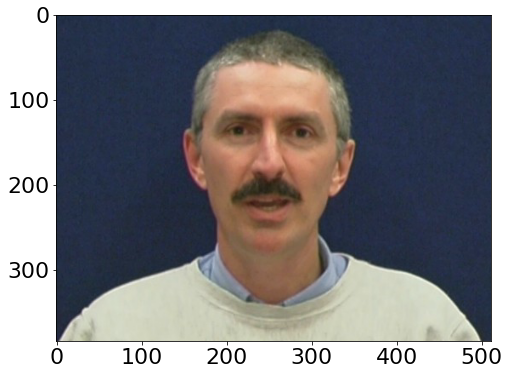

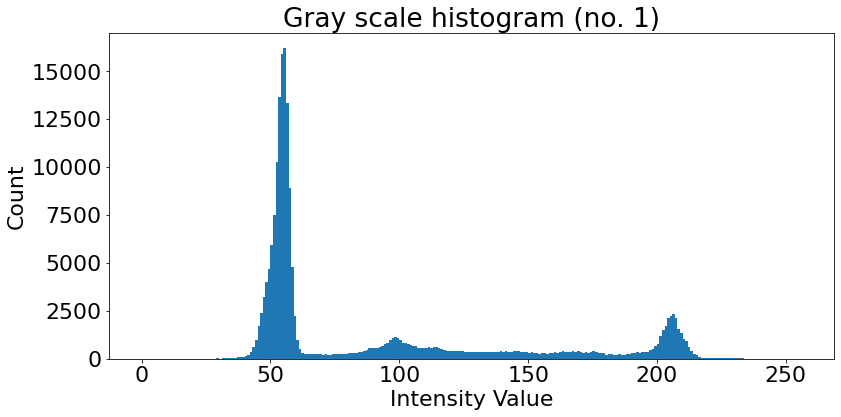

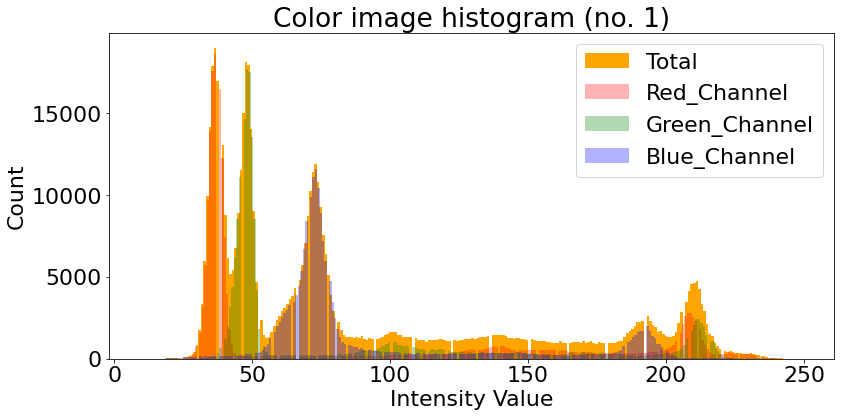

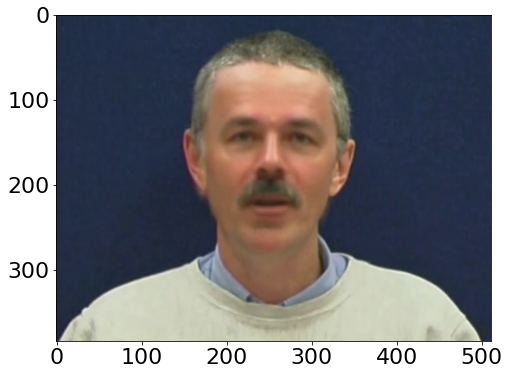

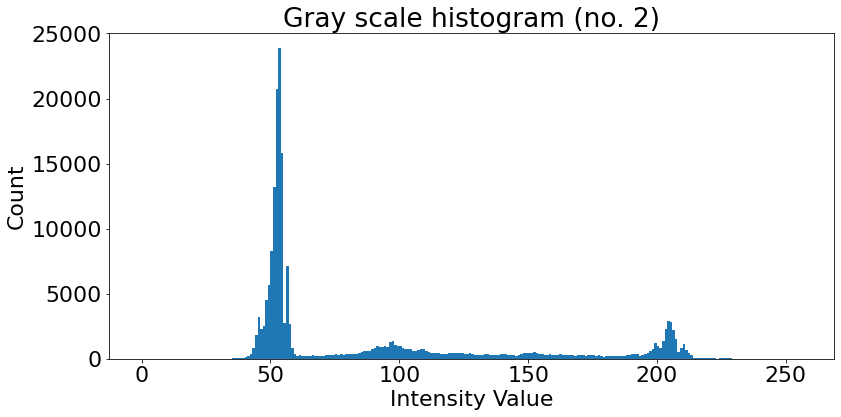

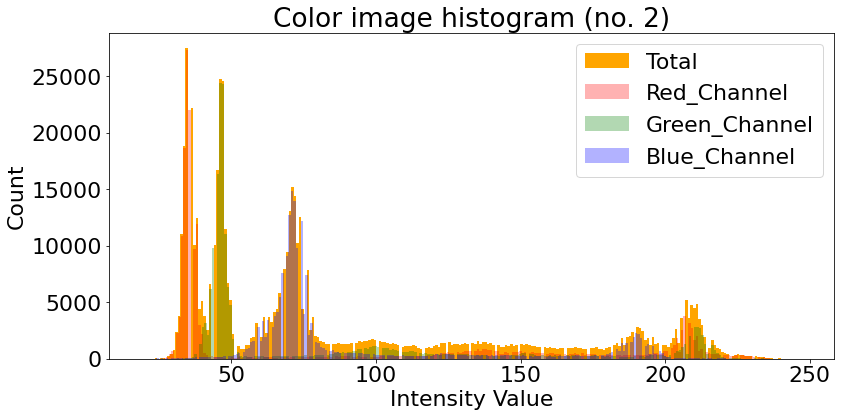

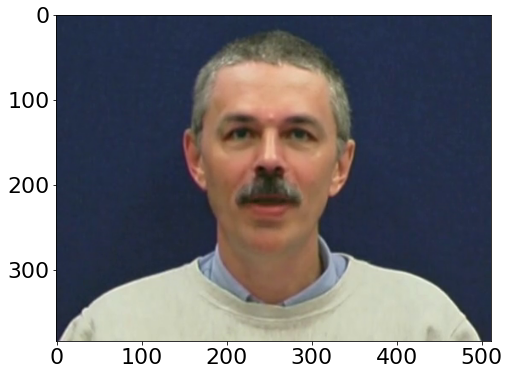

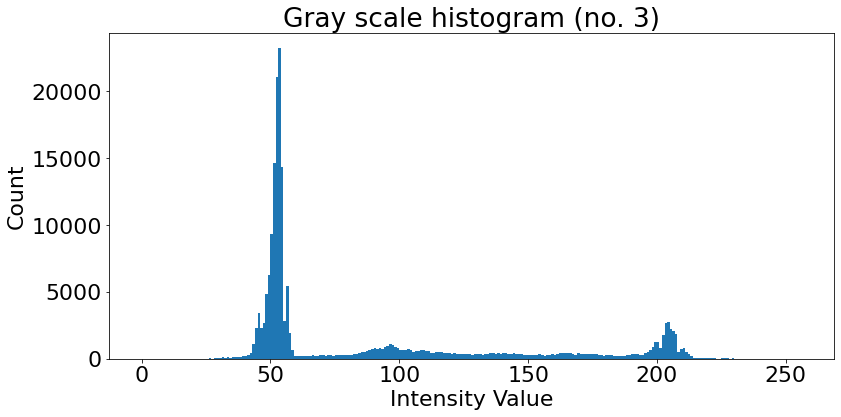

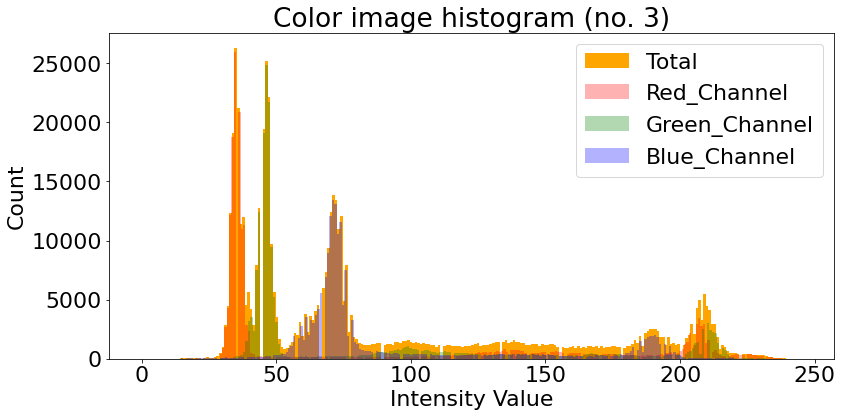

In [57]:
plt.rcParams['figure.figsize'] = [13, 6]
plt.rcParams.update({'font.size': 22})
getting_data(pat, 1, 0)

Visuals above are (in order) frames extracted from video (oryginal, low quality and high quality) and two histograms.

The first visible difference between fakes and oryginal is lack of teeth. Second is the change in berd color. Moreover, the fake images both have strange dot on the forehead and straight nose when man on the oryginal image has slightly curved nose. Beside those rather minor inequalities the lower quality image has some kind of blur near face boundaries.

Visual analysis of histograms reveals that, in case of deep fake frames, count of intensity values near to 50 is much greater. To properly analyse histograms the distance must be measured due to their similarity.

/home/ricz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


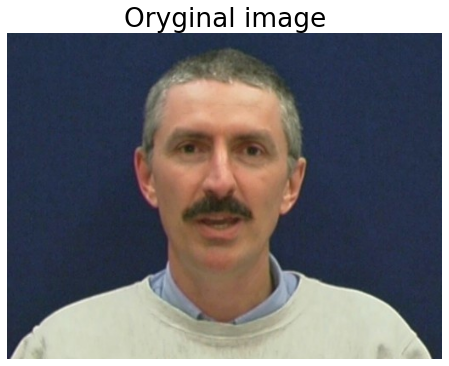

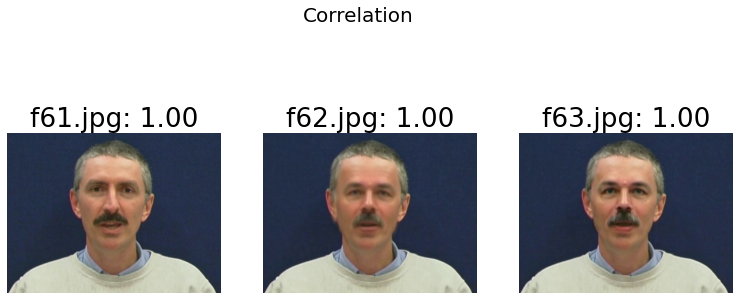

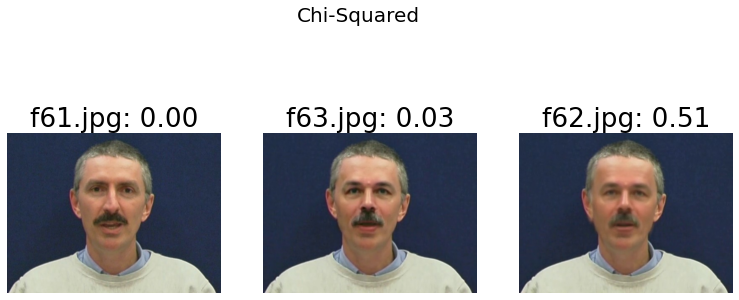

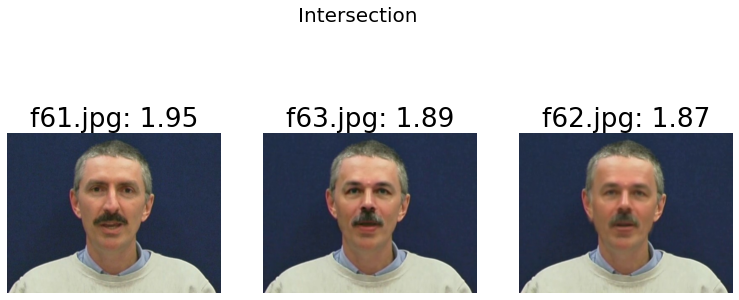

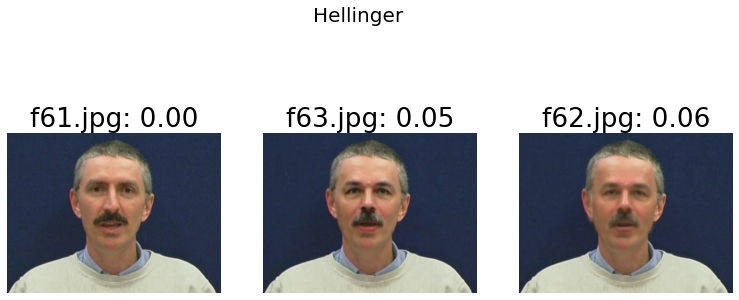

SSIM: 0.9260164138229875
SSIM: 0.9177290332746106


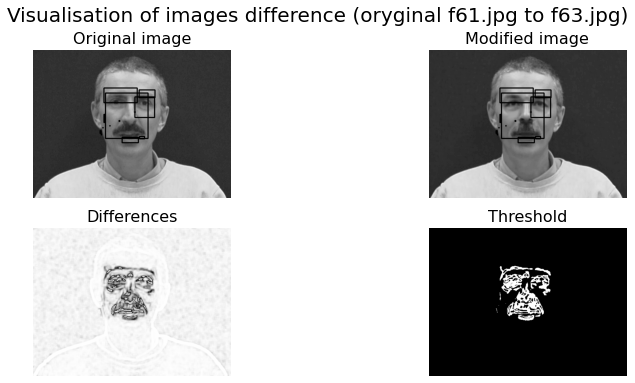

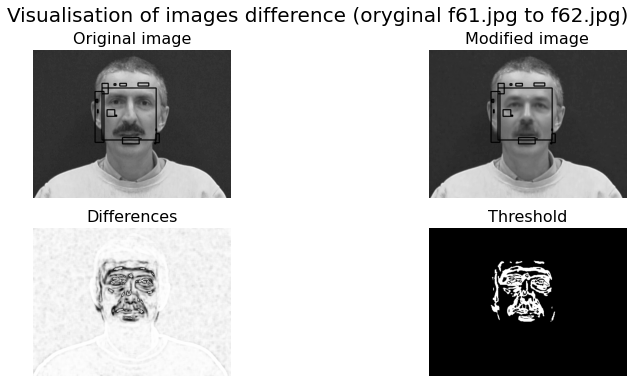

In [59]:
index = {}		# initialize the index dictionary to store the image name
images = {}		# and corresponding histograms and the images dictionary
images_gray = {}
				# to store the images themselves
pat = os.getcwd()
for imagePath in glob.glob(pat + "/comparison" + "/*.jpg"):    # loop over the image paths
	filename = imagePath[imagePath.rfind("/") + 1:]
	image = cv2.imread(imagePath)		# load the image, updating the images dictionary
	images[filename] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	images_gray[filename] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],
				[0, 256, 0, 256, 0, 256])
	hist = cv2.normalize(hist, hist).flatten()
	index[filename] = hist

OPENCV_METHODS = (  	# initialize OpenCV methods for histogram comparison
	("Correlation", cv2.HISTCMP_CORREL),
	("Chi-Squared", cv2.HISTCMP_CHISQR),
	("Intersection", cv2.HISTCMP_INTERSECT),
	("Hellinger", cv2.HISTCMP_BHATTACHARYYA))
for (methodName, method) in OPENCV_METHODS: 	# loop over the comparison methods
	results = {}
	reverse = False
	# if we are using the correlation or intersection
	# method, then sort the results in reverse order
	if methodName in ("Correlation", "Intersection"):
		reverse = True

	# loop over the index
	for (k, hist) in index.items():		# compute the distance between the two histograms
		d = cv2.compareHist(index['f61.jpg'], hist, method)
		results[k] = d
	results = sorted([(v, k) for (k, v) in results.items()], reverse = reverse)
	fig = plt.figure("Query")		# show the query image
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(images["f61.jpg"])
	ax.set_title("Oryginal image")
	plt.axis("off")
	# initialize the results figure
	fig = plt.figure("Results: %s" % (methodName))
	fig.suptitle(methodName, fontsize = 20)
	# loop over the results
	for (i, (v, k)) in enumerate(results):
		# show the result
		ax = fig.add_subplot(1, len(images), i + 1)
		ax.set_title("%s: %.2f" % (k, v))
		plt.imshow(images[k])
		plt.axis("off")
plt.show()

######################################################################################
# saving the differences on images as a image
######################################################################################

origin = images_gray["f61.jpg"].copy()
for (k, image) in images_gray.items():	
	images_gray["f61.jpg"] = origin.copy()
	im = image
	if k != "f61.jpg":
		(score, diff) = ssim(origin, im, full = True)
		diff = (diff * 255).astype("uint8")
		print("SSIM: {}".format(score))
		# threshold the difference image, followed by finding contours to
		# obtain the regions of the two input images that differ
		thresh = cv2.threshold(diff, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		# loop over the contours
		for c in cnts:
			# compute the bounding box of the contour and then draw the
			# bounding box on both input images to represent where the two
			# images differ
			(x, y, w, h) = cv2.boundingRect(c)
			cv2.rectangle(images_gray["f61.jpg"], (x, y), (x + w, y + h), (0, 0, 255), 2)
			cv2.rectangle(im, (x, y), (x + w, y + h), (0, 0, 255), 2)
		# show the output images
		fig_2 = plt.figure("Query {}".format(k))	# show the query image
		fig_2.suptitle("Visualisation of images difference (oryginal f61.jpg to {})".format(k), fontsize = 20)
		plt.subplot(221)
		plt.imshow(images_gray["f61.jpg"], cmap='gray')
		plt.axis("off")
		plt.title("Original image", fontsize = 16)
		plt.subplot(222)
		plt.imshow(im, cmap='gray')
		plt.axis("off")
		plt.title("Modified image", fontsize = 16)
		plt.subplot(223)
		plt.imshow(diff, cmap='gray')
		plt.axis("off")
		plt.title("Differences", fontsize = 16)
		plt.subplot(224)
		plt.imshow(thresh, cmap='gray')
		plt.axis("off")
		plt.title("Threshold", fontsize = 16)
	else:
		pass

plt.show()

Correlation of those images is strangely equal to 1. It indicates very strong linear relatinship between calculated histograms. Intersection of two histograms performed poorly due to strong similarity of colors. Hellinger distance shows slight difference between fakes and oryginal but almost none between two fakes.

Better view on those is given by Chi-Square distance. It means that higher quality deep fake frame, as its histogram, is very close to the oryginal.

Differences between frames, visualized by rectangles and threshold images, are complementary to those spotted at the beggining (beard colour differences, blur near the lower quality face).

# Detect Faces in Videos using OpenCV Viola-Jones face detection algorithm

## Objective:

    Use OpenCV or MTCNN face detectors to detect faces in each frame of the videos. OpenCV has very simple and popular Viola-Jones face detection algorithm. It is simple and fast and will work well on the videos from DeepfakeTIMIT database, since the videos show one person talking in front of the camera and the face is quite large. MTCNN is a neural network-based face detector and is more accurate than the one in OpenCV. Which face detector you use for this project is not important; you can select the one you prefer or whichever you find easier to use.



## Workflow:

    1. Load a video and loop through its frames.
    2. Use Viola-Jones method provided in OpenCV to detect faces for each video frame of a given video. You can also use more advanced tools, for instance, the pre-trained MTCNN model is popular and has a higher accuracy of face detection.
    3. Crop the detected faces and save them as images. Note that you can use different sizes of cropping rectangles. You can either take the rectangle that face detector gives you or you can enlarge it slightly (e.g., by 10–20%) and it may improve (or degrade) the accuracy of Deepfake detection of your overall system. Basically, the size of the face that you crop out of the video frame is a parameter of your system. By changing it, you can achieve different detection results.



It is possible to update previous code to fulfill those tasks using Viola-Jones algorithm.

In [54]:
f = 1
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')   # load the pre-trained model
pat = os.getcwd()
path = pat    # making global copy because glob was changing the path in jupyther (no such problems stationary)

def getting_faces(pat, sample_rate, count):
	''' function iterates recurively through direcory files and
	saves the frames of encountered videos to three folders
	1 - oryginal videos, 2 - lower quality deep fakes, 
	3 - higher quality deep fakes'''
	global path
	for filename in glob.iglob(pat+'/*',
						recursive = True): 		# 1 (from Workflow list)
		if 'mgwt0'in filename and 'avi' in filename and 'sx99' in filename:			
			cap = cv2.VideoCapture(filename)
			total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
			for fno in range(0, total_frames, sample_rate):
				cap.set(cv2.CAP_PROP_POS_FRAMES, fno)
				image, frame = cap.read()
				global f 						# using global variable to update folders
				global classifier
				bboxes = classifier.detectMultiScale(frame)
				for box in bboxes:
					# extract
					x, y, w, h = box
					cropped_img = frame[y-15:y+h+15,x:x+w]		# leaving the x parameter as detected and y larger to fit in the blur on lower quality images
					cv2.imwrite(os.path.join(path, 
									str(f)+'d', 'f{}.jpg'.format(count)), cropped_img)
				count += 1						# updating the frame number
			f += 1								# updating global variable
			getting_faces(filename, 1, 0)			# recursion
		else:
			getting_faces(filename, 1, 0)			# recursion in case actual folder is not the desired one


In [55]:
plt.rcParams['figure.figsize'] = [13, 6]
plt.rcParams.update({'font.size': 22})
getting_faces(pat, 1, 0)

Plotting the sample cropped faces to check if above script worked properly.

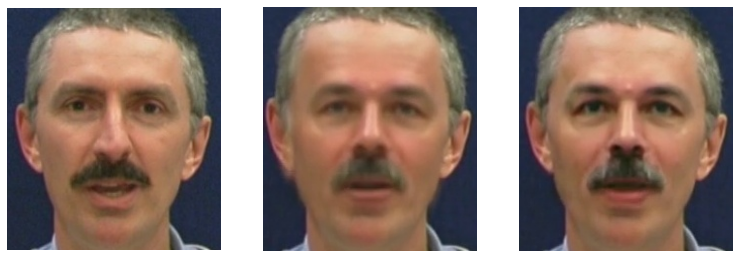

In [50]:
plt.subplot(131)
image = cv2.imread(os.path.join(pat, '1d', 'f60.jpg'))
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));
plt.subplot(132)
image = cv2.imread(os.path.join(pat, '2d', 'f60.jpg'))
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));
plt.subplot(133)
image = cv2.imread(os.path.join(pat, '3d', 'f60.jpg'))
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Summary

Above scripts performed well. They spotted the differences in central face parts and issues like blur in lower quality case. Viola-Jones algorithm is sufficient enough for this simple of face cropping.